In [1]:
import torch, os, copy, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib import colors as mcolors

from src.mechanism_base import *
from src.model_base import EmbedMLP
from src.utils import cross_entropy_high_precision, acc_rate

# Check if GPU is available
os.environ["CUDA_VISIBLE_DEVICES"] = os.environ.get("VSCODE_PROXY_CUDA_DEVICE", "") 
# os.environ["CUDA_VISIBLE_DEVICES"] = os.environ["VSCODE_PROXY_CUDA_DEVICE"]       
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
print(f"Loading on device: {device}")

plt.rcParams['mathtext.fontset'] = 'cm'



Loading on device: cpu


In [2]:
# Define the base path where the model and data files are stored

base_path = '../saved_models/p_23_dmodel_23_dmlp_512_act_Quad_decay_0_fractrain_1_DFT_05171330' # Full random, Quad, Small Init, SGD
# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'Quad'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

# Define the file names for the model and data files
model_file = 'final.pth'        # File containing the trained model
train_data_file = 'train_data.pth'  # File containing the training data
test_data_file = 'test_data.pth'   # File containing the test data

# Load the model and data on the specified device
# Note: The `weights_only=True` argument assumes a custom loader function or a modified PyTorch function. 
# It is not standard in PyTorch's `torch.load`. This should be clarified or corrected.
model_data = torch.load(
    os.path.join(base_path, model_file),   # Path to the model file
    weights_only=True,                    # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                   # Specify the device to load the model onto
)
print(f"Trained Model Dict: {model_data.keys()}\n")  # Print the keys of the loaded model dictionary

# Load the training and testing data
train_data = torch.load(
    os.path.join(base_path, train_data_file),  # Path to the training data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)
test_data = torch.load(
    os.path.join(base_path, test_data_file),   # Path to the testing data file
    weights_only=True,                         # Load weights only (non-standard argument; ensure compatibility)
    map_location=device                        # Specify the device to load the data onto
)

# Extract the model parameters from the loaded model dictionary
model_load = model_data["model"]  # Access the model section of the dictionary
for key in model_load.keys():
    # Print each model parameter's key and its shape in a formatted manner
    print(f"{key:<30} {str(model_load[key].shape):<25}")

Trained Model Dict: dict_keys(['model', 'train_loss', 'test_loss', 'train_losses', 'test_losses', 'grad_norms', 'param_norms', 'epoch', 'optimizer', 'scheduler'])

embed.W_E                      torch.Size([23, 23])     
mlp.W_in                       torch.Size([512, 23])    
mlp.W_out                      torch.Size([23, 512])    
mlp.basis                      torch.Size([23, 23])     


In [3]:
all_data = torch.tensor([(i, j) for i in range(p) for j in range(p)]).to(device)
all_labels = torch.tensor([(i + j) % p for i, j in all_data]).to(device)
train_labels = torch.tensor([(i + j) % p for i, j in train_data]).to(device)

fourier_basis, fourier_basis_names = get_fourier_basis(p, device)
fourier_basis_unstd, _ = get_fourier_basis_unstd(p, device)

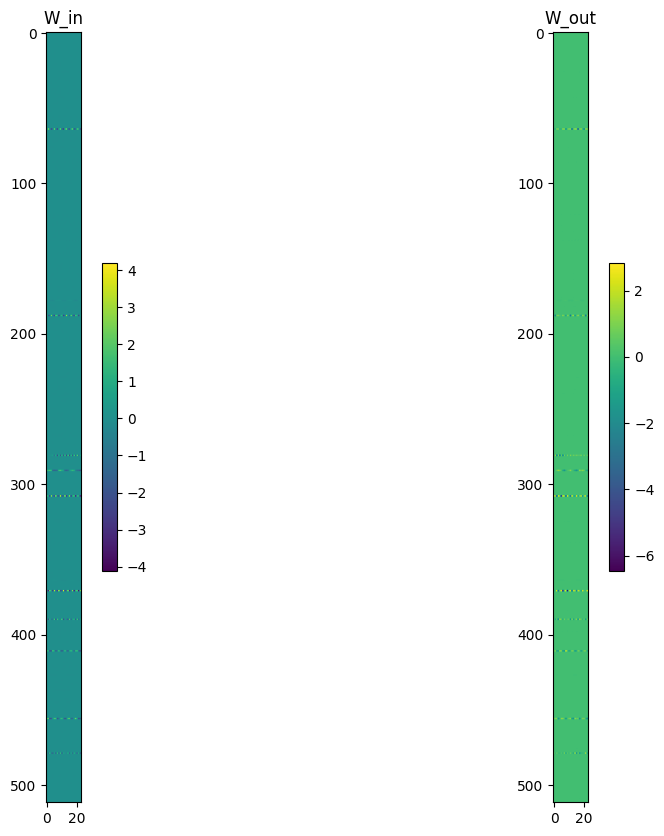

In [4]:
# Plot all four figures in one row
plt.figure(figsize=(12, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#plt.imshow(model_load['mlp.W_in'] @ model_load['embed.W_E'], cmap='viridis')
plt.imshow(model_load['mlp.W_in'], cmap='viridis')
plt.title(f'W_in')
plt.colorbar(shrink=0.4)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2) 
plt.imshow(model_load['mlp.W_out'].T, cmap='viridis')
plt.title(f'W_out')
plt.colorbar(shrink=0.4)

plt.show()

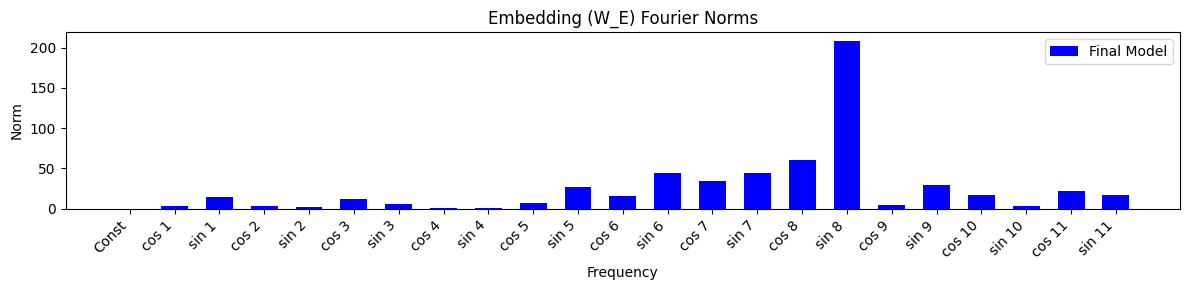

In [5]:
# Compute the norms of the Fourier components
#norms = (model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
norms = (model_load['mlp.W_out'].T @ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()
#norms = (model_load['mlp.W_in']@ fourier_basis.T).pow(2).sum(0).detach().cpu().numpy()

# Plot the bar plot for "embed.W_E"
fig, ax = plt.subplots(figsize=(12, 3))

# x-axis labels
labels = fourier_basis_names
x = np.arange(len(labels))  # Frequency indices
width = 0.6  # Width of the bars

# Plot bars for the final model
ax.bar(x, norms, width, label="Final Model", color="blue")

# Customize plot
ax.set_title("Embedding (W_E) Fourier Norms")
ax.set_ylabel("Norm")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add x-axis label and adjust layout
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

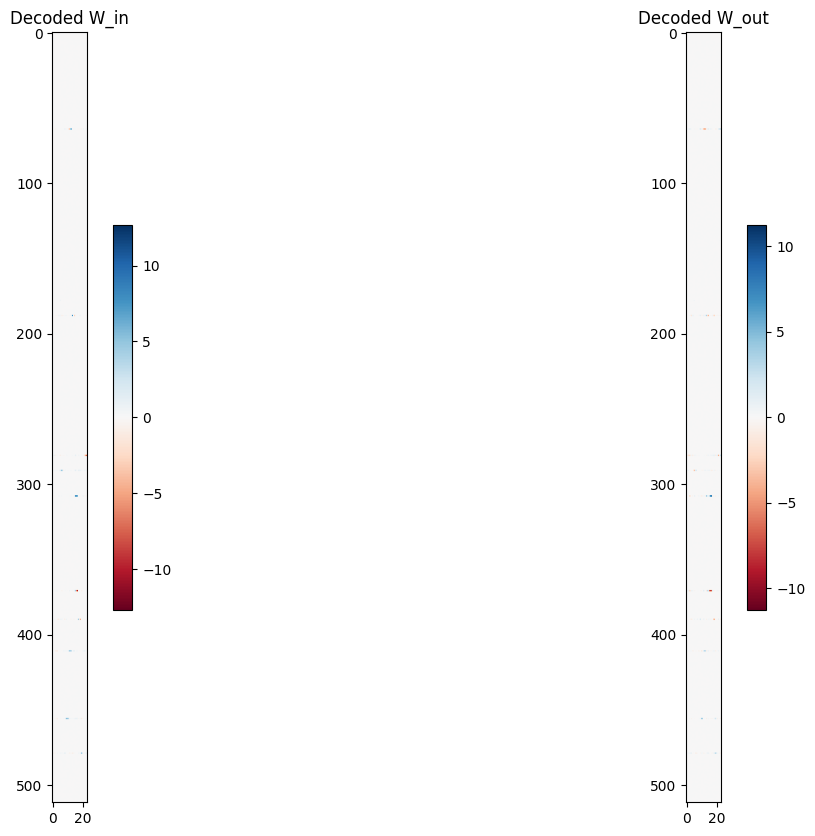

In [6]:
# Plot all four figures in one row
plt.figure(figsize=(15, 10))

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 1)
#data = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis.T
data = model_load['mlp.W_in'] @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_in')
plt.colorbar(shrink=0.5)

# Heatmap (Binary Matrix from train_data)
plt.subplot(1, 2, 2)
data = model_load['mlp.W_out'].T @ fourier_basis.T
abs_max = np.abs(data).max()
plt.imshow(data, cmap='RdBu', vmin=-abs_max, vmax=abs_max)
plt.title(f'Decoded W_out')
plt.colorbar(shrink=0.5)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

plt.show()

In [7]:
def decode_weights(model_load, fourier_basis_unstd):
    """
    Decodes the weights using the given model and Fourier basis, and computes the maximum frequency list.

    Parameters:
        model_load (dict): A dictionary containing the model's weights.
        fourier_basis_unstd (torch.Tensor): The Fourier basis matrix.

    Returns:
        tuple: A tuple containing:
            - W_in_decode (torch.Tensor): Decoded weights for W_in.
            - W_out_decode (torch.Tensor): Decoded weights for W_out.
            - max_freq_ls (list): List of maximum frequencies derived from W_in_decode.
    """
    # Decode the weights
    #W_in_decode = model_load['mlp.W_in'] @ model_load['embed.W_E'] @ fourier_basis_unstd.T
    W_in_decode = model_load['mlp.W_in'] @ fourier_basis_unstd.T
    W_out_decode = model_load['mlp.W_out'].T @ fourier_basis_unstd.T

    # Find the maximum frequency list
    max_ls = torch.argmax(abs(W_in_decode), dim=1)
    max_freq_ls = [(id.item() + 1) // 2 for id in max_ls]

    return W_in_decode, W_out_decode, max_freq_ls

In [8]:
W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
coeff_in_scale_ls_all = []
coeff_out_scale_ls_all = []
coeff_phi_ls_all = []
coeff_psi_ls_all = []

for neuron in range(d_mlp):
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_in_scale_ls_all.append(coeff_in_scale)
    coeff_phi_ls_all.append(coeff_in_phi)
    coeff_psi_ls_all.append(coeff_out_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]} , Scale {coeff_in_scale:.2f},{coeff_out_scale:.2f}, 2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, Phi(out) {coeff_out_phi:.2f}")

Neuron 0: Freq 0 , Scale 0.00,-0.00, 2*Phi(in) 0.00, Phi(out) 0.00
Neuron 1: Freq 4 , Scale 0.01,0.01, 2*Phi(in) 1.50, Phi(out) 1.47
Neuron 2: Freq 1 , Scale 0.01,0.01, 2*Phi(in) -1.76, Phi(out) -1.68
Neuron 3: Freq 7 , Scale 0.01,0.00, 2*Phi(in) -2.42, Phi(out) -2.49
Neuron 4: Freq 8 , Scale 0.02,0.01, 2*Phi(in) 0.07, Phi(out) 0.08
Neuron 5: Freq 11 , Scale 0.00,0.00, 2*Phi(in) -2.60, Phi(out) -2.69
Neuron 6: Freq 3 , Scale 0.00,0.00, 2*Phi(in) -3.11, Phi(out) -2.87
Neuron 7: Freq 10 , Scale 0.02,0.02, 2*Phi(in) -3.07, Phi(out) -3.09
Neuron 8: Freq 10 , Scale 0.00,0.00, 2*Phi(in) -2.75, Phi(out) -2.73
Neuron 9: Freq 9 , Scale 0.01,0.01, 2*Phi(in) 0.39, Phi(out) 0.33
Neuron 10: Freq 10 , Scale 0.01,0.01, 2*Phi(in) 0.92, Phi(out) 0.85
Neuron 11: Freq 1 , Scale 0.01,0.00, 2*Phi(in) 2.87, Phi(out) 3.05
Neuron 12: Freq 6 , Scale 0.02,0.01, 2*Phi(in) -0.50, Phi(out) -0.52
Neuron 13: Freq 10 , Scale 0.01,0.01, 2*Phi(in) -1.58, Phi(out) -1.54
Neuron 14: Freq 3 , Scale 0.01,0.01, 2*Phi(in) -1.

In [9]:
coeff_scale_ls = []
coeff_phi_ls = []
freq = 2

for neuron in [i for i, value in enumerate(max_freq_ls) if value == freq]:
    coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
    coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
    coeff_scale_ls.append(coeff_in_scale*coeff_out_scale)
    coeff_phi_ls.append(coeff_in_phi)
    print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, Scale(in,out) {coeff_in_scale: .2f},{coeff_out_scale: .2f}, Phi(out) {normalize_to_pi(coeff_out_phi): .2f}, Phi(in)*2 {normalize_to_pi(2*coeff_in_phi): .2f}")

coeff_scale_ls = np.array(coeff_scale_ls)
coeff_phi_ls = np.array(coeff_phi_ls)

#for i in [1,2,4,6]: print(f"*{i} Mean of Sin: {np.mean(np.sin(i*coeff_phi_ls))} Mean of Cos: {np.mean(np.cos(i*coeff_phi_ls))}")
#for i in [1,2,4]: print(f"*{i} Sin: {np.mean(coeff_scale_ls*np.sin(i*coeff_phi_ls))/np.mean(coeff_scale_ls)} Cos: {np.mean(coeff_scale_ls*np.cos(i*coeff_phi_ls))/np.mean(coeff_scale_ls)}")
#plot_angles_on_circle(coeff_phi_ls)
#print(sum(coeff_scale_ls**3))

Neuron 25: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  0.40, Phi(in)*2  0.40
Neuron 26: Freq 2, Scale(in,out)  0.05, 0.04, Phi(out)  0.35, Phi(in)*2  0.38
Neuron 27: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  1.10, Phi(in)*2  1.08
Neuron 39: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  2.66, Phi(in)*2  2.71
Neuron 43: Freq 2, Scale(in,out)  0.05, 0.04, Phi(out)  2.00, Phi(in)*2  1.97
Neuron 52: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  2.64, Phi(in)*2  2.64
Neuron 54: Freq 2, Scale(in,out)  0.01, 0.00, Phi(out) -0.01, Phi(in)*2  0.28
Neuron 55: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  2.29, Phi(in)*2  2.30
Neuron 60: Freq 2, Scale(in,out)  0.01, 0.00, Phi(out)  1.77, Phi(in)*2  1.64
Neuron 68: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out) -0.70, Phi(in)*2 -0.67
Neuron 90: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out) -2.06, Phi(in)*2 -2.02
Neuron 95: Freq 2, Scale(in,out)  0.01, 0.01, Phi(out)  0.67, Phi(in)*2  0.62
Neuron 116: Freq 2, Scale(in,out)  0.01, 0.00, Phi(out) -1.04, P

# Process Checking

In [10]:
all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

In [11]:
def plot_model(key):
    # Retrieve the model state dict using the selected key
    model_load = loaded_files[key]
    
    # Create the figure with two subplots
    plt.figure(figsize=(15, 10))
    
    # First subplot: Decoded W_in
    plt.subplot(1, 2, 1)
    # Compute data (example: W_in multiplied by the transpose of the fourier_basis)
    data_in = model_load['mlp.W_in'] @ fourier_basis.T
    abs_max_in = np.abs(data_in).max()
    plt.imshow(data_in, cmap='RdBu', vmin=-abs_max_in, vmax=abs_max_in)
    plt.title('Decoded W_in')
    plt.colorbar(shrink=0.5)
    
    # Second subplot: Decoded W_out
    plt.subplot(1, 2, 2)
    # Compute data (example: transpose of W_out multiplied by the transpose of the fourier_basis)
    data_out = model_load['mlp.W_out'].T @ fourier_basis.T
    abs_max_out = np.abs(data_out).max()
    plt.imshow(data_out, cmap='RdBu', vmin=-abs_max_out, vmax=abs_max_out)
    plt.title('Decoded W_out')
    plt.colorbar(shrink=0.5)

    plt.suptitle(f'Model Key: {key}')
    plt.show()

# Create a selection slider with the sorted keys from your loaded_files dictionary
key_options = sorted(loaded_files.keys())
interact(plot_model, key=widgets.SelectionSlider(options=key_options, description='Model Key'));


interactive(children=(SelectionSlider(description='Model Key', options=(0, 100, 200, 300, 400, 500, 600, 700, …

In [12]:
def interactive_model(key):
    # Clear previous outputs so the new model's output is shown clearly
    clear_output(wait=True)
    
    # Retrieve the model using the selected key
    model_load = loaded_files[key]
    
    # Decode the weights from the selected model
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model_load, fourier_basis)
    
    # Determine the number of neurons (assuming the first dimension of W_in_decode equals d_mlp)
    d_mlp = W_in_decode.shape[0]
    print(f"Loaded Model Key: {key} with {d_mlp} neurons.\n")
    
    # Loop through each neuron and print the computed details
    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        print(f"Neuron {neuron}: Freq {max_freq_ls[neuron]}, "
              f"Scale {coeff_in_scale:.4f},{coeff_out_scale:.4f}, "
              f"2*Phi(in) {normalize_to_pi(2*coeff_in_phi):.2f}, "
              f"Phi(out) {coeff_out_phi:.2f}",
              f"Scale Diff {coeff_in_scale**2-2*coeff_out_scale**2:.8f}")

# Create an interactive widget for model selection using the keys in loaded_files.
model_keys = sorted(loaded_files.keys())
interact(interactive_model, key=widgets.SelectionSlider(options=model_keys, description='Model Key'));



interactive(children=(SelectionSlider(description='Model Key', options=(0, 100, 200, 300, 400, 500, 600, 700, …

In [13]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Decode this model’s weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)


    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

In [14]:
# specify the neuron you care about
neuron_id = 59  # change to your desired neuron index

# collect per‐model vectors
scales_list = []
diff_list   = []

for model in loaded_files.values():
    # decode all freqs for this model’s W_in
    scales, phis, psis = decode_scales_phis(model, fourier_basis)
    # pick out this neuron’s row
    scales_list.append(scales[neuron_id])  # Tensor[K+1]
    diff_list.append(normalize_to_pi(psis[neuron_id] - 2*phis[neuron_id]))    # Tensor[K+1]

# stack into two big tensors of shape (num_models, K+1)
scales_all = torch.stack(scales_list, dim=0)[:,1:]
diff_all   = torch.stack(diff_list,   dim=0)[:,1:]

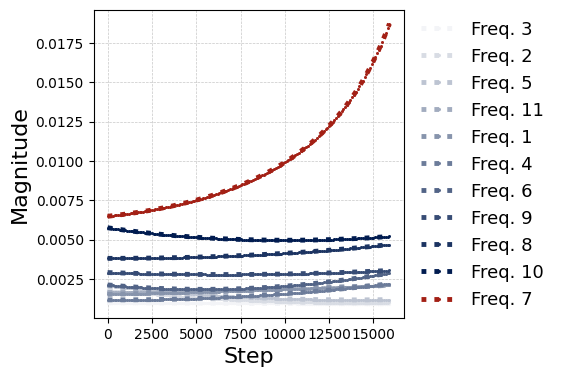

In [15]:
# your palette
colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186', '#0064E0']
base_rgb        = np.array(mcolors.to_rgb(colors[0]))
gray_rgb        = np.array(mcolors.to_rgb('white'))
highlight_color = colors[3]
max_freq        = 6   # frequency to highlight

# assume scales_all is already defined: Tensor[num_models, K+1]
scales_np = scales_all.cpu().numpy()
scales_np = scales_np[:160]
num_models, num_freqs = scales_np.shape
x = np.arange(num_models)

# order the non-highlight freqs by their final-scale value
final_scales  = scales_np[-1]
nonmax        = [f for f in range(num_freqs) if f != max_freq]
sorted_nonmax = sorted(nonmax, key=lambda f: final_scales[f])
M = len(sorted_nonmax)

# create a larger figure + main axes
fig, ax = plt.subplots(figsize=(4, 4))  # increased size

# plot non-highlight freqs in a gradient from white → base color
for idx, f in enumerate(sorted_nonmax):
    blend = idx / (M - 1) if M > 1 else 0.0
    col_rgb = (1 - blend -0.05) * gray_rgb + (blend +0.05)* base_rgb
    ax.plot(x, scales_np[:, f],
            color=col_rgb,
            linestyle=':',
            marker='x',
            linewidth=3.5,
            markersize=1.5,
            label=f"Freq. {f+1}")

# plot the highlighted max_freq
ax.plot(x, scales_np[:, max_freq],
        color=highlight_color,
        linestyle=':',
        marker='x',
        linewidth=3.5,
        markersize=1.5,
        label=f"Freq. {max_freq+1}")

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{int(val*100)}"))

# put legend on the right, outside the plot
ax.legend(loc='upper left',
          bbox_to_anchor=(1.02, 1),
          borderaxespad=0.2,
          frameon=False,
          fontsize=13)

# grid & labels
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Magnitude", fontsize=16)
#ax.set_title(f"Neuron {neuron_id} scales across models", fontsize=14)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('figures/lottery_mech_magnitude.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


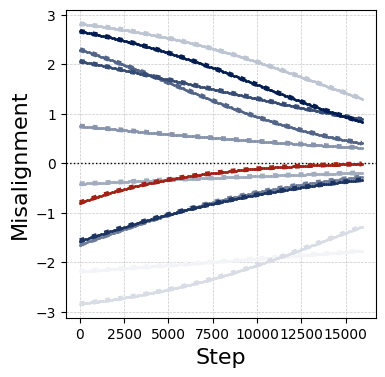

In [16]:
# assume diff_list is a torch.Tensor[num_models, K+1]
diff_np = diff_all.cpu().numpy()
diff_np = diff_np[:160]
num_models, num_freqs = diff_np.shape
x = np.arange(num_models)

# order the non-highlight freqs by their final diff value
final_diffs   = diff_np[-1]
#nonmax        = [f for f in range(num_freqs) if f != max_freq]
#sorted_nonmax = sorted(nonmax, key=lambda f: final_diffs[f])
M = len(sorted_nonmax)

# create a larger figure + main axes
fig, ax = plt.subplots(figsize=(4, 4))

ax.axhline(y=0,
           color='black',
           linewidth=1,
           linestyle='dotted')

# plot non-highlight freqs in a gradient from white → base color
for idx, f in enumerate(sorted_nonmax):
    blend = idx / (M - 1) if M > 1 else 0.0
    col_rgb = (1 - blend - 0.05) * gray_rgb + (blend + 0.05) * base_rgb
    ax.plot(x, diff_np[:, f],
            linestyle=':',
            marker='x',
            linewidth=3.5,
            markersize=1.5,
            color=col_rgb,
            label=f"Freq. {f}")

# plot the highlighted max_freq
ax.plot(x, diff_np[:, max_freq],
        linestyle=':',
        marker='x',
        linewidth=3.5,
        markersize=1.5,
        color=highlight_color,
        label=f"Freq. {max_freq}")

ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f"{int(val*100)}"))

# put legend on the right, outside the plot
# ax.legend(loc='upper left',
#           bbox_to_anchor=(1.02, 1),
#           borderaxespad=0.,
#           fontsize=14)

# grid & labels
ax.set_xlabel("Step", fontsize=16)
ax.set_ylabel("Misalignment", fontsize=16)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig('figures/lottery_mech_phase.jpg', format='jpg', dpi=300, bbox_inches='tight')

plt.show()


In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap
from mechanism_base import get_fourier_basis, get_fourier_basis_unstd, normalize_to_pi


def gradient_update(theta, xi, init_k, p, device):
    # Compute Fourier coefficients for theta and xi
    fourier_basis, _ = get_fourier_basis(p, device)
    # Ensure that the fourier_basis has the same dtype as theta and xi
    fourier_basis = fourier_basis.to(theta.dtype)
    theta_coeff = fourier_basis @ theta  
    xi_coeff    = fourier_basis @ xi

    # --- For theta: extract the 2-coefficient vector for neuron 'init_k'
    # Using list indexing to extract two rows from theta_coeff.
    neuron_coeff_theta = theta_coeff[[init_k * 2 - 1, init_k * 2]]
    alpha = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_theta.pow(2))).item()
    phi = np.arctan2(-neuron_coeff_theta[1].item(), neuron_coeff_theta[0].item())
    # print(alpha)
    # print(phi)

    # --- For xi: similarly, extract a 2-element vector (correcting psi_coeff -> xi_coeff)
    neuron_coeff_xi = xi_coeff[[init_k * 2 - 1, init_k * 2]]
    beta = np.sqrt(2/p) * torch.sqrt(torch.sum(neuron_coeff_xi.pow(2))).item()
    psi = np.arctan2(-neuron_coeff_xi[1].item(), neuron_coeff_xi[0].item())

    # --- Compute gradients over the p Fourier modes.
    w_k = 2 * np.pi * init_k / p
    grad_theta = torch.tensor(
        [2 * p * alpha * beta * np.cos(w_k * j + psi - phi) for j in range(p)],
        device=device
    )
    grad_xi = torch.tensor(
        [p * alpha**2 * np.cos(w_k * j + 2 * phi) for j in range(p)],
        device=device
    )

    return grad_theta, grad_xi

def simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device):
    # Lists to store the history (optional)
    theta_history = [theta.clone()]
    xi_history = [xi.clone()]
    
    for step in range(num_steps):
        grad_theta, grad_xi = gradient_update(theta, xi, init_k, p, device)
        # Update parameters using a simple Euler update (gradient descent style)
        theta = theta + learning_rate * grad_theta
        xi = xi + learning_rate * grad_xi
        
        theta_history.append(theta.clone())
        xi_history.append(xi.clone())
        
    return theta_history, xi_history

In [18]:
import pandas as pd

# Simulation hyper-params
device        = torch.device("cpu")
p             = 23
init_k        = 1
init_psi      = 0.0
num_steps     = 1000
learning_rate = 0.01

# Experiment grid
initial_scales = np.linspace(0.001, 0.002, num=30)               # whatever scales you want
phi0_vals      = np.linspace(0, np.pi, num=30)   # e.g. 21 values from 0 to 2π

# Pre-compute Fourier basis once
fourier_basis, _ = get_fourier_basis(p, device)
fourier_basis = fourier_basis.to(torch.get_default_dtype())

results = []

for scale in initial_scales:
    for phi0 in phi0_vals:
        # 1) initialize theta, xi
        w_k   = 2*np.pi*init_k/p
        theta = scale * torch.tensor([np.cos(w_k*j + phi0) for j in range(p)], device=device)
        xi    = scale * torch.tensor([np.cos(w_k*j + init_psi) for j in range(p)], device=device)
        
        # 2) run gradient flow
        th_hist, xi_hist = simulate_gradient_flow(theta, xi, init_k, p, num_steps, learning_rate, device)
        
        # 3) take the last iterate
        th_final, xi_final = th_hist[-1], xi_hist[-1]
        
        # 4) compute final beta and psi, phi
        coeffs_th = fourier_basis.to(th_final.dtype) @ th_final
        coeffs_xi = fourier_basis.to(th_final.dtype) @ xi_final
        idx = [init_k*2-1, init_k*2]
        th_n = coeffs_th[idx]
        xi_n = coeffs_xi[idx]
        
        factor = np.sqrt(2/p)
        phi_f = np.arctan2(-th_n[1].item(), th_n[0].item())
        beta_f = factor * torch.norm(xi_n).item()
        psi_f  = np.arctan2(-xi_n[1].item(), xi_n[0].item())
        
        delta_f = normalize_to_pi(2*phi_f - psi_f)
        
        results.append({
            "init_scale": scale,
            "init_diff":  2*phi0,
            "beta_f":  beta_f,
            "delta_f": delta_f
        })

# 5) collect into a DataFrame
df = pd.DataFrame(results)
print(df)

     init_scale  init_diff    beta_f       delta_f
0         0.001   0.000000  0.001400 -6.011602e-08
1         0.001   0.216662  0.001394  5.342192e-02
2         0.001   0.433323  0.001377  1.093508e-01
3         0.001   0.649985  0.001349  1.704654e-01
4         0.001   0.866646  0.001312  2.398045e-01
..          ...        ...       ...           ...
895       0.002   5.416539  0.005175 -2.365240e-02
896       0.002   5.633201  0.005593 -1.469903e-02
897       0.002   5.849862  0.005924 -8.514377e-03
898       0.002   6.066524  0.006138 -3.902125e-03
899       0.002   6.283185  0.006212 -3.780937e-08

[900 rows x 4 columns]


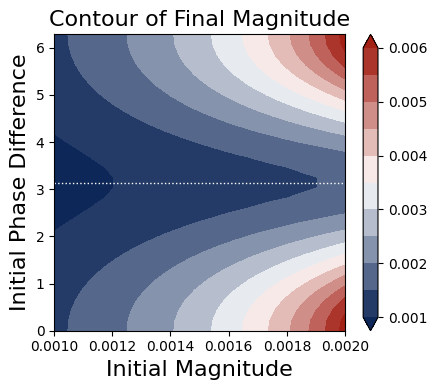

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center',
    ['#0D2758', 'white', '#A32015'],
    N=256
)

# (Re)pivot your DataFrame into a grid
beta_grid = df.pivot(index="init_diff", columns="init_scale", values="beta_f")

# Build mesh for contour
X, Y = np.meshgrid(beta_grid.columns.values, beta_grid.index.values)
Z = beta_grid.values

# Plot the filled contour
plt.figure(figsize=(4.5, 4))
cf = plt.contourf(
    X, Y, Z,
    levels=12,
    cmap=cividis_with_white,
    extend='both'
)

# Add white horizontal line at y = π
plt.axhline(y=np.pi, color='white', linewidth=1, linestyle=':')

plt.xlabel("Initial Magnitude", fontsize=16)
plt.ylabel("Initial Phase Difference", fontsize=16)
plt.title("Contour of Final Magnitude", fontsize=16)
plt.colorbar(cf)
plt.tight_layout()

# Save to file
plt.savefig('../figures/lottery_beta_contour.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()



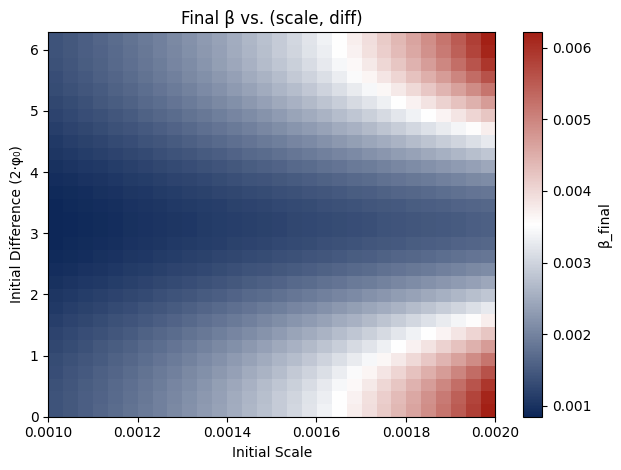

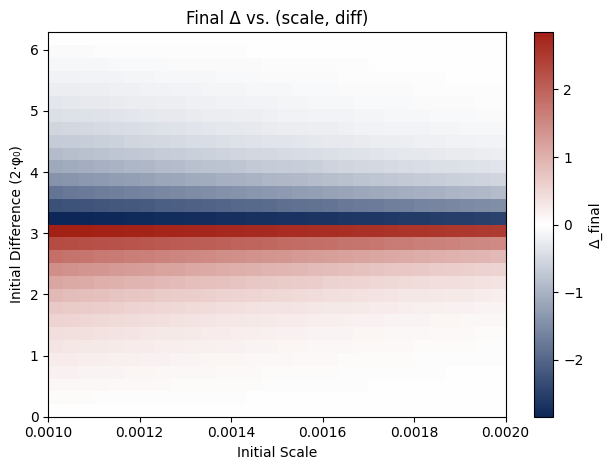

In [20]:
from matplotlib.colors import LinearSegmentedColormap

# define your colormap
cividis_with_white = LinearSegmentedColormap.from_list(
    'cividis_white_center',
    ['#0D2758', 'white', '#A32015'],
    N=256
)

# Pivot into 2D grids
beta_grid  = df.pivot(index="init_diff", columns="init_scale", values="beta_f")
delta_grid = df.pivot(index="init_diff", columns="init_scale", values="delta_f")

# --- Plot final β ---
plt.figure()
plt.imshow(
    beta_grid.values,
    origin="lower",
    aspect="auto",
    extent=[
        beta_grid.columns.min(),
        beta_grid.columns.max(),
        beta_grid.index.min(),
        beta_grid.index.max()
    ],
    cmap=cividis_with_white
)
plt.xlabel("Initial Scale")
plt.ylabel("Initial Difference (2·φ₀)")
plt.title("Final β vs. (scale, diff)")
plt.colorbar(label="β_final")
plt.tight_layout()
plt.show()

# --- Plot final Δ (2φ–ψ) ---
plt.figure()
plt.imshow(
    delta_grid.values,
    origin="lower",
    aspect="auto",
    extent=[
        delta_grid.columns.min(),
        delta_grid.columns.max(),
        delta_grid.index.min(),
        delta_grid.index.max()
    ],
    cmap=cividis_with_white
)
plt.xlabel("Initial Scale")
plt.ylabel("Initial Difference (2·φ₀)")
plt.title("Final Δ vs. (scale, diff)")
plt.colorbar(label="Δ_final")
plt.tight_layout()
plt.show()

